In [1]:
from GG_mthesis import *
%matplotlib inline

In [2]:
sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set(font_scale=1.2)

In [3]:
#define the path
path = '.\\data\\02_intermediate\\tsg_orchestra\\b1903933_3_select.nc'

#open the dataset with the defined path
ds = xr.open_dataset(path) 

In [4]:
ds

<xarray.Dataset>
Dimensions:           (time: 2726)
Coordinates:
    lat               (time) float64 ...
    lon               (time) float64 ...
    depth             (time) float32 ...
  * time              (time) datetime64[ns] 2017-11-09T02:12:59.999680 ... 2017-11-10T23:37:59.997824
Data variables:
    attenuation       (time) float32 ...
    conductivity_tsg  (time) float32 ...
    chl-a             (time) float32 ...
    sal_tsg_cal       (time) float32 ...
    sal_tsg_nocal     (time) float32 ...
    temp_hull_1       (time) float32 ...
    temp_hull_2       (time) float32 ...
    temp_cond_tsg     (time) float32 ...
Attributes:
    date_update:  2020-07-31T01:05:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  trajectory
    title:        SeaDataNet NETCDF TRAJECTORY Climate Forecast 1.6 - GENERAT...

In [5]:
#Let's calculate the distances
distance = []
for coord in range(len(ds.lat)-1):
    distance.append(utils.geo.getPathLength(ds.lat[coord],ds.lon[coord],ds.lat[coord+1],ds.lon[coord+1]))
distance = np.array(distance)

#And the cumulative distance
distance_cum = np.insert(np.cumsum(distance), 0, 0)

ds['distance_cum'] = xr.DataArray(distance_cum,dims={'time':ds.time},coords={'time':ds.time})

[Text(0, 0.5, 'Distance travelled'), Text(0.5, 0, 'Time')]

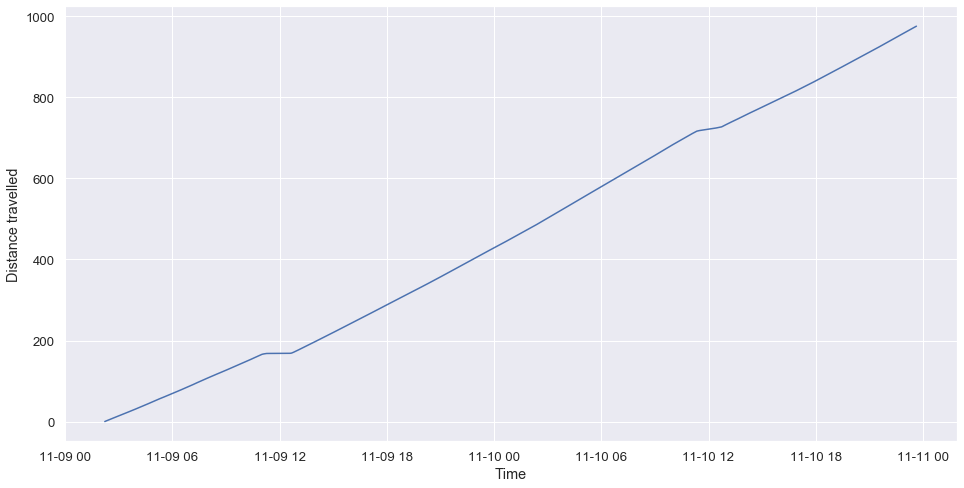

In [6]:
#Let's have a look at the plot distance - time plot

fig, ax0 = plt.subplots(figsize=(16,8))
sns.lineplot(y=ds.distance_cum/1000, x=ds.time)

ax0.set(xlabel='Time', ylabel='Distance travelled')

In [7]:
#Let's calculate each timestep (which should be 1 min)
time_diff = []
for time in range(len(ds.time)-1):
    time_diff.append(np.array((ds.time[time+1]) - np.array(ds.time[time]))/np.timedelta64(1, 's'))
time_diff = xr.DataArray(time_diff,dims={'distance':distance},coords={'distance':distance})

#Now we can calculate the vessel speed
vel = time_diff.distance/time_diff*3.6

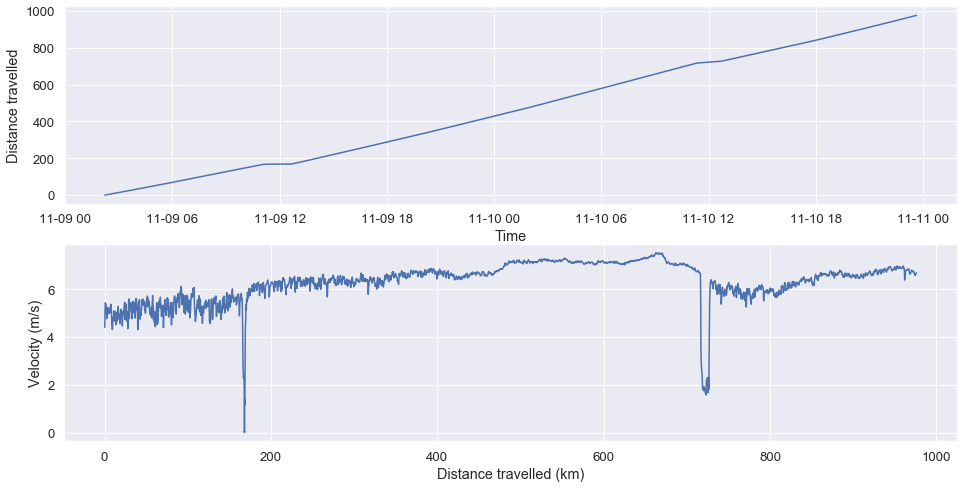

In [8]:
#Let's plot what we have got so far

fig, (ax0, ax1) = plt.subplots(nrows=2,figsize=(16,8))
sns.lineplot(y=ds.distance_cum/1000, x=ds.time, ax=ax0)

sns.lineplot(x=distance_cum[1:]/1000,y=vel/3.6, ax=ax1)

ax0.set(xlabel='Time', ylabel='Distance travelled')
ax1.set(xlabel='Distance travelled (km)', ylabel='Velocity (m/s)')

plt.savefig('C:\\Users\\gian_\\repos\\mthesis_gianlucca\\results\\preprocessing\\vessel_speed.png', bbox_inches='tight', format='png')

In [9]:
#I am going to exclude all the data where the distance is less than 240 m (explanation in fun_with_boat_speed notebook).
#Let's calculate the cumulative distance between sampling points (starting at 0) and introduce it as a coordinate variable in the dataset

In [10]:
#just different method of calculatig the distances. Gonna leave them both for interest.
distance = gsw.distance(np.array(ds.lon), np.array(ds.lat))
distance_cum = np.insert(np.cumsum(distance), 0, 0)
ds['distance_cum'] = xr.DataArray(distance_cum,dims={'time':ds.time},coords={'time':ds.time})
ds = ds.set_coords('distance_cum')
ds['distance_cum'].attrs = {
    'long_name': 'Cumulative distance',
    'standard_name': 'distance_cum',
    'units': 'm',
    'description': 'cumulative distance between sampling points calculated using gsw'
}

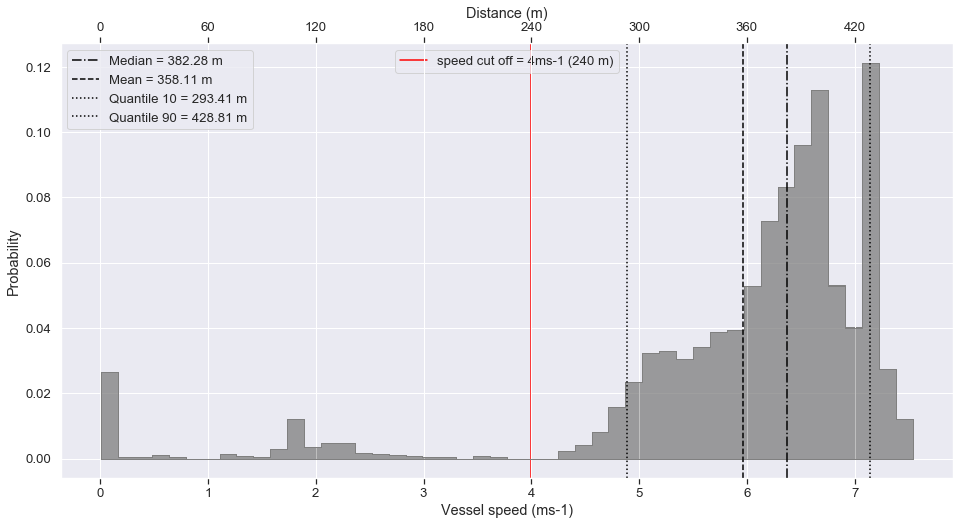

In [11]:
#Let's plot the distances and vessel speed in a histogram, with a cut-off line at 4ms-1

fig, ax0 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(16,8))
ax1 = ax0.twiny()

sns.histplot(vel/3.6, element='step', stat='probability', color='grey', alpha = 0.5, ax=ax0)
sns.histplot(distance, element='step', stat='probability', color='grey', alpha =0.5, ax=ax1)

ax1.axvline(x=np.median(distance), label=str(('Median = ') + str(round(np.median(distance),2)) 
    + str(' m')), color='black', linestyle='-.')
ax1.axvline(x=np.mean(distance), label=str(('Mean = ') + str(round(np.mean(distance),2)) 
    + str(' m')), color='black', linestyle='--')
ax1.axvline(x=np.quantile(distance, .10), label=str(('Quantile 10 = ') + str(round(np.quantile(distance, .10),2)) 
    + str(' m')), color='black', linestyle=':',)
ax1.axvline(x=np.quantile(distance, .90), label=str(('Quantile 90 = ') + str(round(np.quantile(distance, .90),2)) 
    + str(' m')), color='black', linestyle=':')
ax1.legend(loc='upper left')

ax0.axvline(x=4, label='speed cut off = 4ms-1 (240 m)', color='red', linestyle='-')

ax1.set_xticks(np.arange(0, 460, 60))

ax0.set(xlabel='Vessel speed (ms-1)')
ax1.set(xlabel='Distance (m)')

ax0.legend(loc='upper center')

plt.savefig('C:\\Users\\gian_\\repos\\mthesis_gianlucca\\results\\preprocessing\\vessel_speed_hist.png', bbox_inches='tight', format='png')

In [12]:
#In order to select the appropiate data, we have to create a auxilary distance variable with the same len as all the variables (more in variable description).
distance_aux = np.insert(distance, 0, 999) #CAREFUL: if I was to introduce a Nan instead of 999 we would introduce a Nan value in all the variables.
ds['distance_aux'] = xr.DataArray(distance_aux,dims={'time':ds.time},coords={'time':ds.time})
ds['distance_aux'].attrs = {
    'long_name': 'Auxiliary distances',
    'standard_name': 'distance_aux',
    'units': 'm',
    'description': 'Auxiliary variable composed of the distances between datapoint with an additional point inserted as the first value, being 999. This is in order to be able to sample out of the dataset acording to the distance. That way, e.g., if one wanted to sample all values with a distance greater than 200m, the reaching point of each distance sample would be excluded.'
}

#Now we can select by this variable and drop all created NaNs:
ds = ds.where(ds.distance_aux >= 240).dropna('time')

#I have to recalculate the cumulative distances as well:
distance = gsw.distance(np.array(ds.lon), np.array(ds.lat))
distance_cum = np.insert(np.cumsum(distance), 0, 0)
ds['distance_cum'] = xr.DataArray(distance_cum,dims={'time':ds.time},coords={'time':ds.time})
ds = ds.set_coords('distance_cum')
ds['distance_cum'].attrs = {
    'long_name': 'Cumulative distance',
    'standard_name': 'distance_cum',
    'units': 'm',
    'description': 'cumulative distance between sampling points calculated using gsw'
}

#Now we can drop the auxiliary distance variable again.
ds = ds.drop('distance_aux')

In [13]:
#STEPS ALL EXPLAINED IN PREPROCESSING

In [14]:
path_to = '.\\data\\02_intermediate\\tsg_orchestra\\b1903933_4_spatial_res.nc'
ds.to_netcdf(path_to)